<center><h1> Analysis of NYC High School Data | SAT results </h1></center>

## Table of Contents
- [Introduction](#1)
- [Data Exploration](#2)
- [Data Cleaning](#3)
- [Survey Correlations](#4)
- [Safety and SAT Scores](#5)
- [Race and SAT Scores](#6)
- [Gender and SAT Scores](#7)
- [AP Scores and SAT Scores](#8)
- [Class Size and SAT Scores](#9)
- [Conclusion](#10)

# 1

## Introduction
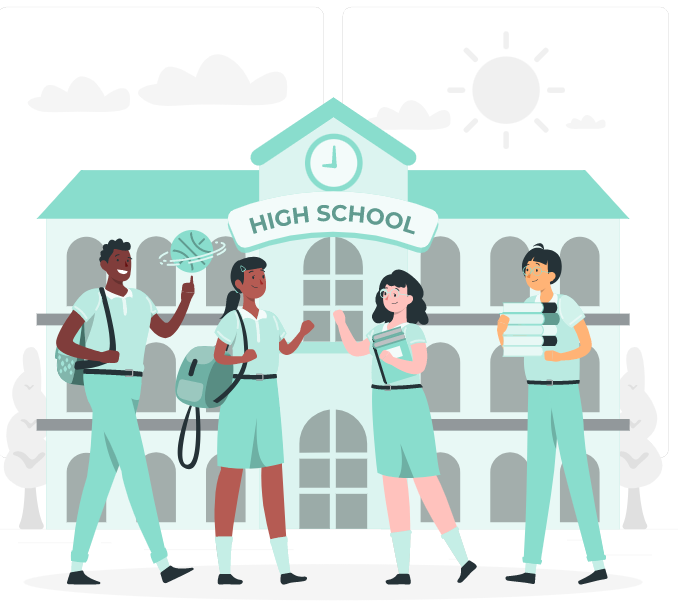

**Source:** [Storyset](https://storyset.com/illustration/high-school/rafiki)


**Motivation:** US colleges base their admission decisions on the results of the nationally standardized "SAT" exam. Making the US educational system more fair is something the US Department of Education describes as a "[formidable issue](https://www.ed.gov/equity)". Undeniably, the effectiveness of standardized examinations and whether they are unjust to particular groups are two of the most contentious topics in the American educational system. I am interested and curious to look at the relationships between SAT scores and demographics. It would be a great idea to link SAT scores to factors like ethnicity, gender, safety, and more.

**Approach Taken:** It is crucial to identify any unintended patterns or reasons that discriminate against specific groups of students. Hence, we must try to find correlations between SAT scores and different factors such as safety, race, gender, AP scores, and class size.

**Data Set:** Along with the demographics for each high school, New York City makes its information on high school SAT results online accessible. However, combining the two data sets won't provide with all of the necessary demographic data. To complete this analysis, more data is required from other sources.


The following datasets on NYC high schools and SAT results will be used in the analysis (the data set for our research is based on 2,400 total SAT points, however this figure has changed a few times):
- [School Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j)
- [SAT Results by School](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)
- [School Attendance and Enrollment Statistics by District](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt)
- [Class Size by Grade and Program Type](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
- [Graduation Outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a)
- [AP School Level Results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e)
- [School Surveys](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)

# 2

## Data Exploration
### Import Libraries

In [1]:
from tqdm.notebook import tqdm_notebook # progress bar for geocoding
import tqdm
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata  # api calls
import geopy  # reverse geocoding
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly as py  # interactive plots
import plotly.graph_objs as go
import folium
import branca.colormap as cm
import cufflinks as cf  # interactive plots in pandas style
from plotly.offline import iplot, init_notebook_mode # offline mode
cf.go_offline(connected = True)
init_notebook_mode(connected = True)
%matplotlib inline

# avoiding display of truncated columns 
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 60

pd.options.display.float_format = '{:,.3f}'.format # pandas display format

### Read in Data

In [2]:
data_files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv'
]

data = {}

for f in data_files:
    d = pd.read_csv('schools/{0}'.format(f))
    data[f.replace('.csv', '')] = d
    
data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results'])

### Exploring the SAT Data
The SAT data set, which is represented by the dictionary key ```sat_results```, is what we're most interested in, so let's investigate it.

In [3]:
print('Total Rows:', data['sat_results'].shape[0])
print('Total Columns:', data['sat_results'].shape[1])

data['sat_results'].head()

Total Rows: 478
Total Columns: 6


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


**Insights:**

- It appears that each school's ```DBN``` serves as a unique ID.


- The first few rows of names indicate that the information we have solely relates to high schools.


- Since each high school only has one record, each ```DBN``` in the SAT data is unique.


- In order to make the SAT scores easier to examine, we may ultimately want to merge the three columns that include SAT scores — ```SAT Critical Reading Avg. Score```, ```SAT Math Avg. Score```, and ```SAT Writing Avg. Score``` — into a single column.

### Exploring the Remaining Data
Let's explore the remaining data so that we can grasp an overall idea about this dataset.

In [4]:
for key in data:
    print(data[key].head(), '\n')
    print('Total Rows:', data[key].shape[0])
    print('Total Columns:', data[key].shape[1], '\n', '\n' )

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s   

Total Rows: 258
Total Columns: 5 
 

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto

**Insights:**
- All the data sets seem to have either a ```DBN``` column or the required details to generate one. Therefore, we may join the data sets using a ```DBN``` column. By searching for identical DBNs, we will first identify matching rows from several data sets and then combine all of their columns into a single data set.

- ```Location 1``` field, which provides coordinates inside a longer string, stands out as being particularly interesting for mapping.

- There appear to be numerous rows for each school in some of the data sets (because the rows have duplicate ```DBN``` values). Therefore, some preparation will be required to guarantee that each ```DBN``` is *distinct* inside each data set. Failure to do so, will cause issues when joining the data sets.

### Reading In & Exploring Surveys

The survey data files such as ```survey_all.txt``` and ```survey_d75.txt``` use ```Windows-1252``` encoding and are tab delimited.

In [5]:
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding = 'windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding = 'windows-1252')
survey = pd.concat([all_survey, d75_survey], axis = 0)

print('Total Rows:', survey.shape[0])
print('Total Columns:', survey.shape[1])
survey.head()

Total Rows: 1702
Total Columns: 2773


,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,N_s,N_t,N_p,nr_s,nr_t,...,s_q12g_1,s_q12g_2,s_q12g_3,s_q12g_4,s_q14_1,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.000,Elementary School,nan,88,60,nan,22.000,90.000,0,25,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.000,Elementary School,nan,100,60,nan,34.000,161.000,0,33,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.000,Elementary School,nan,88,73,nan,42.000,367.000,0,48,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.000,Elementary / Middle School,89.000,73,50,145.000,29.000,151.000,163,40,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,01M063,M063,P.S. 063 William McKinley,0,No,0.000,Elementary School,nan,100,60,nan,23.000,90.000,0,23,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


**Insights:**

- The data set has nearly 3000 columns, almost all of which are unnecessary. Data cleaning needs to be done in order to get rid of the irrelevant information. Less columns will make it simpler to print the dataframe and look for relationships within it.


- Another step needs to be taken is changing the ```dbn``` column from lowercase to uppercase (```DBN```). With the conversion, the column name will be consistent with those in the other data sets.

# 3

## Data Cleaning

### Identifying Relevant Columns
First step is to duplicate the data from ```dbn``` to a new column called ```DBN``` before filtering columns out. Then, we can choose, filter, and delete the irrelevant columns. The data dictionary, which is accessible in the repository, may be useful for choosing the appropriate columns.

In [6]:
survey['DBN'] = survey['dbn']

survey_fields = [
    'DBN', 
    'rr_s', 
    'rr_t', 
    'rr_p', 
    'N_s', 
    'N_t', 
    'N_p', 
    'saf_p_11', 
    'com_p_11', 
    'eng_p_11', 
    'aca_p_11', 
    'saf_t_11', 
    'com_t_11', 
    'eng_t_11', 
    'aca_t_11', 
    'saf_s_11', 
    'com_s_11', 
    'eng_s_11', 
    'aca_s_11', 
    'saf_tot_11', 
    'com_tot_11', 
    'eng_tot_11', 
    'aca_tot_11',
]
survey = survey.loc[:,survey_fields]
data['survey'] = survey

print('Total Rows:', survey.shape[0])
print('Total Columns:', survey.shape[1])
survey.head()

Total Rows: 1702
Total Columns: 23


,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,nan,88,60,nan,22.000,90.000,8.500,7.600,7.500,7.800,7.500,7.800,7.600,7.900,nan,nan,nan,nan,8.000,7.700,7.500,7.900
1,01M019,nan,100,60,nan,34.000,161.000,8.400,7.600,7.600,7.800,8.600,8.500,8.900,9.100,nan,nan,nan,nan,8.500,8.100,8.200,8.400
2,01M020,nan,88,73,nan,42.000,367.000,8.900,8.300,8.300,8.600,7.600,6.300,6.800,7.500,nan,nan,nan,nan,8.200,7.300,7.500,8.000
3,01M034,89.000,73,50,145.000,29.000,151.000,8.800,8.200,8.000,8.500,7.000,6.200,6.800,7.800,6.200,5.900,6.500,7.400,7.300,6.700,7.100,7.900
4,01M063,nan,100,60,nan,23.000,90.000,8.700,7.900,8.100,7.900,8.400,7.300,7.800,8.100,nan,nan,nan,nan,8.500,7.600,7.900,8.000


### Inserting DBN fields
After looking at each data set, we saw that several of them lacked a ```DBN``` field, including ```class_size``` and ```hs_directory```. But since ```hs_directory``` does have a ```dbn``` field, we can simply rename it. Although, another issue appears: it doesn't seem like that column exists in ```class_size``` at all. So, let's take a look at that. 

In [7]:
print(data['class_size'].head())
print('\n')
print(data['sat_results'].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


It appears that the ```DBN``` in the ```sat_results``` data is basically ```CSD``` and ```SCHOOL CODE``` columns combined together in the ```class_size``` data. The key distinction is that the ```DBN``` is padded, ensuring that the ```CSD``` part of it always consists of two digits. Therefore, if the ```CSD``` is less than two digits long, we must add a leading 0.

Now, we can insert ```DBN``` columns as unique identifier in datasets where they are not yet present.

In [8]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

def pad_csd(num):
    string = str(num)
    if len(string) > 1:
        return string
    else:
        return '0' + string
    
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.000,1.000,19.000,19.000,19.000,ATS,nan,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.000,1.000,21.000,21.000,21.000,ATS,nan,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.000,1.000,17.000,17.000,17.000,ATS,nan,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.000,1.000,17.000,17.000,17.000,ATS,nan,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.000,1.000,15.000,15.000,15.000,ATS,nan,01,01M015


### Joining SAT Scores
The next thing to do is adding up the SAT scores for the various exam parts and displaying the result in a new column. Dealing with one number will be much simpler instead of three, and it'll help link results with demographic parameters.

Let's first convert the scores from **object** (string) data type to **numeric** data type, and then create a new column.

In [9]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for col in cols:
    data['sat_results'][col] = pd.to_numeric(data['sat_results'][col], errors = 'coerce')

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

### Geographic Coordinate Parsing for Schools
For each school, we'll need to decode the latitude and longitude coordinates so that we can map the schools and look for any regional trends in the data. The ```hs_directory``` data set has ```Location 1``` field which contains the coordinates.

In [10]:
data['hs_directory']['Location 1'].head()

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.670298907000...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026690005, -7...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.842414068000494...
3    411 Pearl Street\nNew York, NY 10038\n(40.71067947100045...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40.718810094...
Name: Location 1, dtype: object

It appears that there's a lot of unnecessary information. The only relevant part are the coordinates included in the parentheses at the end, so let's exctract that.

In [11]:
pattern = r'\((.+),(.+)\)'
data['hs_directory'][['lat','lon']] = data['hs_directory']['Location 1'].str.extract(pattern).astype(float)

### Combining and Condensing Data Sets
As mentioned before, it's possible to merge the data sets together using the ```DBN``` column.

Firstly, the data sets must be filtered so that the ```DBN``` column contains only discrete values, otherwise, the problems will arise when combining them. It's great that the most important data set ```sat_results``` has every high school in NYC with a unique ```DBN``` number, what we can't tell about other data sets - those are less consistent. For instance, a single row in the ```class_size``` data set may match numerous rows in the ```sat_results``` data set. Hence, condensing the ```class_size```, ```demographics```, and```graduation``` data sets to make each ```DBN``` unique will be required.

Let's take a closer look at the ```class_size``` data set.

In [12]:
class_size = data['class_size']
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.000,1.000,19.000,19.000,19.000,ATS,nan,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.000,1.000,21.000,21.000,21.000,ATS,nan,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.000,1.000,17.000,17.000,17.000,ATS,nan,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.000,1.000,17.000,17.000,17.000,ATS,nan,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.000,1.000,15.000,15.000,15.000,ATS,nan,01,01M015


The ```DBN``` occurs more than once because the first few rows all belong to the same school. The values for ```GRADE```, ```PROGRAM TYPE```, ```CORE SUBJECT```, and ```CORE COURSE``` seem to vary depending on the school.

In [13]:
print(class_size['GRADE '].value_counts(),'\n')
print(class_size['PROGRAM TYPE'].value_counts())

09-12      10644
MS Core     4762
0K-09       1384
0K          1237
01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
Name: GRADE , dtype: int64 

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64


First of all, let's take into the consideration only grades 9 through 12 because the analysis is about high schools. Therefore, we'll need to choose rows when the value of the ```GRADE``` column is between ```09``` and ```12```. 

Secondly, it's better to just choose rows where ```PROGRAM TYPE``` is ```GEN ED``` because it's by far the largest group. 

Last but not least, not only a portion of the classes that a school provides, but all of them, should be included in ```class_size``` data set. We can use the average of all the courses a school provides as a solution. This will provide with uniwue ```DBN``` values and ensure that the average includes the most data.

In [14]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

class_size = class_size.groupby('DBN').agg(numpy.mean).reset_index()
data['class_size'] = class_size
data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.000,4.000,22.564,18.500,26.571,nan
1,01M332,1,46.000,2.000,22.000,21.000,23.500,nan
2,01M378,1,33.000,1.000,33.000,33.000,33.000,nan
3,01M448,1,105.688,4.750,22.231,18.250,27.062,nan
4,01M450,1,57.600,2.733,21.200,19.400,22.867,nan


____

Next, we need to condense the ```demographics``` data set. Let's take a closer look at it.

In [15]:
demographics = data['demographics']
demographics.head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,...,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,nan,281,15,36,40,33,38,52,29,38,NaN,...,20.300,25,9,10,3.600,74,26.300,189,67.300,5,1.800,158.000,56.200,123.000,43.800
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,nan,243,15,29,39,38,34,42,46,NaN,NaN,...,22.600,19,15,18,7.400,68,28.000,153,63.000,4,1.600,140.000,57.600,103.000,42.400
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,nan,261,18,43,39,36,38,47,40,NaN,NaN,...,23.000,20,14,16,6.100,77,29.500,157,60.200,7,2.700,143.000,54.800,118.000,45.200
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,nan,252,17,37,44,32,34,39,49,NaN,NaN,...,24.600,21,17,16,6.300,75,29.800,149,59.100,7,2.800,149.000,59.100,103.000,40.900
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.500,208,16,40,28,32,30,24,38,NaN,NaN,...,22.100,14,14,16,7.700,67,32.200,118,56.700,6,2.900,124.000,59.600,84.000,40.400


It appears that the ```schoolyear``` is the column that prevents ```DBN``` from being unique. Besides, the rows with the ```schoolyear``` **2011–2012** should be only selected; this will provide with the most current year of data (based on our data set) and match the our SAT results data.

In [16]:
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

_____

Next, we need to condense the ```graduation``` data set. Let's take a closer look at it.

In [17]:
graduation = data['graduation']
graduation.head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,0,0%,0%,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,0,0%,0%,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,0,0%,0%,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


In [18]:
print(graduation['Demographic'].unique(),'\n')
print(graduation['Cohort'].value_counts())

['Total Cohort' 'Male' 'English Language Learners'
 'English Proficient Students' 'Special Education Students'
 'General Education Students' 'Asian' 'Black' 'Hispanic' 'White' 'Female'] 

2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: Cohort, dtype: int64


It seems that ```DBN``` cannot be distinguished from other graduates in the ```graduation``` data set because of the ```Demographic``` and ```Cohort``` columns. ```Demographic``` appears to relate to a particular demographic group, whereas the term ```Cohort``` appears to refer to the year the data reflects. 

We should use data from the **2006** ```Cohort``` because it's the most recent one that is currently accessible. Additionally, it's better to have information from the whole cohort, thus let's only choose rows where ```Demographic``` is ```Total Cohort```.

In [19]:
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

### Converting AP Scores
Many high school students take the Advanced Placement (AP) examinations, especially those who attend schools with academically rigorous requirements. AP examinations are far less common in schools with insufficient funds or academic difficulty. A passing score on an AP test is 3 or above on a scale of 1 to 5.

For the analysis, AP test results should first be changed from **object** (strings) to **numeric** value in the ```ap_2010``` data set.

Conversion is needed for these three columns: ```AP Test Takers```, ```Total Exams Taken```, ```Number of Exams with scores 3 4 or 5```.

In [20]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors = 'coerce')

### Combining the Datasets
It's better to use a **left join** to combine the ```sat_results``` data set with the ```graduation``` and ```ap_2010``` data sets because each of them contain a large number of missing ```DBN``` entries. The final dataframe will contain all of the ```DBN``` values from the first ```sat_results``` dataframe as we're applying a left join.

Next, there still will be a need to combine ```class_size```, ```survey```, ```hs_directory```, and ```demographics``` into combined dataframe after conducting the left joins. For that matter, the **inner join** type will be the best option since these data sets have data that is more beneficial to our research and also have less missing ```DBN``` entries.

In [21]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

### Missing Values
Let's fix problem of the missing values with the means of all columns. If mean doesn't exist, let's insert 0.

In [22]:
means = combined.mean()
combined = combined.fillna(means)
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,...,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.000,404.000,363.000,"1,122.000",0,129.029,197.038,153.450,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.000,...,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who attend an in...,Then to New York City residents who attend an informatio...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.000,0.000,0.000,"220 Henry Street\nNew York, NY 10002\n(40.71376394700047...",40.714,-73.985
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.000,423.000,366.000,"1,172.000",UNIVERSITY NEIGHBORHOOD H.S.,39.000,49.000,10.000,Total Cohort,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124.000,...,Not Functionally Accessible,3,Open to New York City residents,For M35B only: Open only to students whose home language...,0,0,0,0,0,0.000,0.000,0.000,"200 Monroe Street\nNew York, NY 10002\n(40.7123318510005...",40.712,-73.985
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.000,402.000,370.000,"1,149.000",EAST SIDE COMMUNITY HS,19.000,21.000,153.450,Total Cohort,EAST SIDE COMMUNITY SCHOOL,2006,90.000,...,Not Functionally Accessible,1,Priority to continuing 8th graders,Then to New York City residents,0,0,0,0,0,0.000,0.000,0.000,"420 East 12 Street\nNew York, NY 10009\n(40.729782687000...",40.730,-73.983
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.000,433.000,384.000,"1,207.000",0,129.029,197.038,153.450,Total Cohort,MARTA VALLE HIGH SCHOOL,2006,84.000,...,Functionally Accessible,1,Priority to District 1 students or residents,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0.000,0.000,0.000,"145 Stanton Street\nNew York, NY 10002\n(40.720569079000...",40.721,-73.986
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND MATH HIGH ...",159,522.000,574.000,525.000,"1,621.000","NEW EXPLORATIONS SCI,TECH,MATH",255.000,377.000,191.000,Total Cohort,NEW EXPLORATIONS INTO SCIENCE TECHNO,2006,46.000,...,Not Functionally Accessible,1,Priority to continuing 8th graders,Then to New York City residents,0,0,0,0,0,0.000,0.000,0.000,"111 Columbia Street\nNew York, NY 10002\n(40.71872545100...",40.719,-73.979


### New Column for School District
A great approach to examine the statistics is to map them out by school district. A way to do this is by creating a column in the data set that indicates the school district. Just the first two letters of the ```DBN``` indicate the school district. So, let's extract the first two letters from the combined ```DBN``` column.

In [23]:
combined['school_dist'] = combined['DBN'].str[0:2]
combined['school_dist'].head()

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

# 4

## Survey Correlations
There are a number of fields that were generated from a survey of parents, teachers, and students. It would be a great idea to display the relationships between these fields and ```sat_score```.

Firstly, ```DBN``` field should be removed since it's a unique identifier rather than a correlation-relevant numerical number. Then, we can compute all correlations with SAT scores as the last step before displaying the visualization.

In [24]:
survey_fields.remove('DBN')

correlations = combined.corr()
correlations = correlations['sat_score']

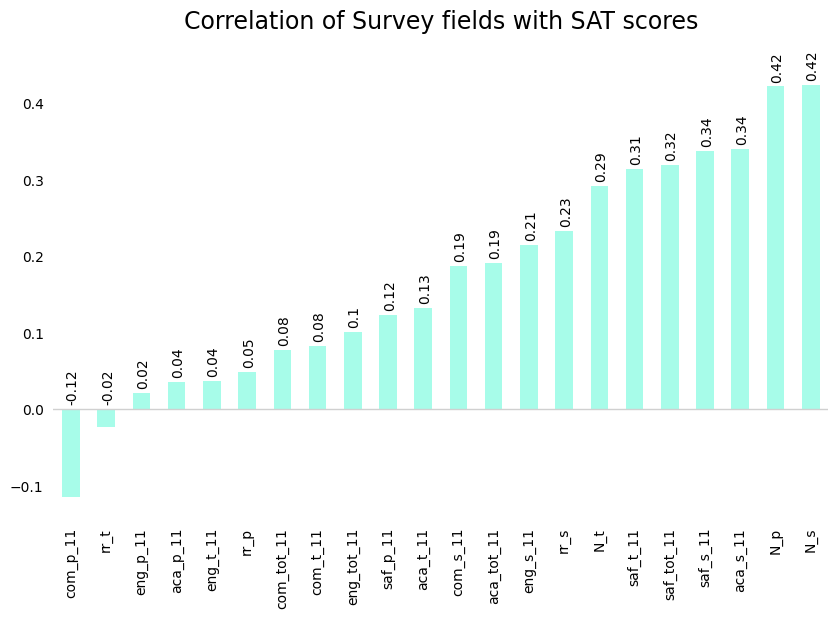

In [25]:
ax = combined.corr()['sat_score'][survey_fields].sort_values().plot.bar(color = '#a7fce9', figsize = (10, 6))

for key, spine in ax.spines.items():
       spine.set_visible(False)
        
for i in ax.patches:
    ax.annotate(str(round(i.get_height(), 2)),
               (i.get_x() + 0.1, max(i.get_height(), 0) + 0.01),
                rotation = 90
               )
ax.tick_params(bottom = False, top = False, left = False, right = False, labelbottom = True) 
ax.set_title('Correlation of Survey fields with SAT scores\n', size = 17)
ax.axhline(y = 0.0, color = '#D0D0D0', linestyle = '-', linewidth = 1)

plt.rcParams['figure.dpi'] = 300

**Insights:**
- There are some quite high correlations between ```N_s```, ```N_t```, ```N_p```, and ```sat_score```. Given their relationship to *overall enrolment*, it seems reasonable that these columns would be high.


- The correlation between ```rr_s```, or the *student response rate*, and ```sat_score``` is what makes this correlation more interesting. This may make logical sense since students who are more likely to participate in surveys may also be more likely to be performing well in class.


- Another interesting correlation is that ```aca_s_11```, *which measures how academic standards are seen by students*, corresponds with ```sat_score```, but not ```aca_t_11```, which measures how *standards are perceived by teachers*, or ```aca_p_11```, which measures *standards as perceived by parents*.


- The ```sat_score``` and how teachers and students perceived *safety* (```saf_t_11``` and ```saf_s_11```) are correlated. This makes sense given that learning and teaching are more difficult tasks in dangerous settings.

# 5

## Safety and SAT scores
The previous visualization showed a strong correlation between ```saf_t_11``` and ```saf_s_11```, which assess instructors' and students' perceptions of school safety. Let's delve a little deeper into this connection and attempt to identify the schools with the lowest safety ratings.

The great way to display the safety data would be by map. However, due to the huge number of schools, it would be quite hard to interpret the map visualization. Aggregating granular statistics might be the best approach to make highly detailed data easier to understand. Thus, let's aggregate by **district** so that we may visualize data and display the map district by district rather than school by school.

In [26]:
districts = combined.groupby("school_dist").mean().reset_index()
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,...,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833,473.333,439.333,"1,354.500",116.681,173.019,135.800,93.500,1.000,115.244,5.149,22.675,18.798,26.553,...,7.447,7.433,6.817,7.117,7.683,12.000,12.000,"10,003.167",659.500,1.333,0.000,0.000,0.000,40.719,-73.982
1,02,426.619,444.186,424.833,"1,295.638",128.908,201.517,157.496,158.648,2.000,149.819,5.686,25.038,20.663,28.594,...,7.385,7.521,6.721,7.038,7.542,12.000,12.000,"10,023.771",621.396,1.417,0.000,0.000,0.000,40.740,-73.991
2,03,428.530,437.998,426.916,"1,293.443",156.183,244.522,193.087,183.384,3.000,156.006,5.839,23.716,19.738,27.123,...,7.375,7.233,6.617,6.892,7.392,12.000,12.000,"10,023.750",717.917,2.000,0.000,0.000,0.000,40.782,-73.977
3,04,402.143,416.286,405.714,"1,224.143",129.016,183.879,151.036,113.857,4.000,132.362,5.193,24.101,19.741,27.460,...,7.571,7.714,6.943,7.186,7.786,12.000,12.000,"10,029.857",580.857,1.143,0.000,0.000,0.000,40.793,-73.943
4,05,427.160,438.237,419.666,"1,285.063",85.723,115.725,142.464,143.677,5.000,120.624,4.845,24.290,20.448,27.747,...,7.286,7.086,6.414,6.671,7.314,12.000,12.000,"10,030.143",609.857,1.143,0.000,0.000,0.000,40.817,-73.949


In [27]:
# set a baselayer and zoom-in on NYC
map_nyc = folium.Map(location = [40.693943, -73.985880], 
                        zoom_start = 11,
                        tiles = 'CartoDB positron')

# create a title
title_map = 'NYC High Schools: Safety Score & Average Enrollment by School District'
title_html = '''
             <h3 align='center' style='font-size:20px'><b>{}</b></h3>
             '''.format(title_map)
map_nyc.get_root().html.add_child(folium.Element(title_html))

# column names for vizual parameters
size_parameter = 'total_enrollment'
color_parameter = 'saf_s_11'

# colormap for cirles on the map
start_val = districts[color_parameter].min()
end_val = districts[color_parameter].max()
start_hex = '#ff78d9'
end_hex = '#75ffdf'
colormap = cm.LinearColormap(colors = [start_hex, end_hex], vmin = start_val, vmax = end_val)
colormap.caption = 'Safety Score by Students Response'

# circle for each school district
for index, row in districts.iterrows():
    folium.Circle(location = [row['lat'], row['lon']],
                  color = colormap(row[color_parameter]),
                  fill_color = colormap(row[color_parameter]),
                  fill_opacity = 0.76,
                  radius = row[size_parameter],
                  weight = 2,
                  tooltip = 'District ' + row['school_dist'] +
                      ' <br> Average Safety Score by Students Response (color): {:.1f}'.format(row[color_parameter]) +
                      ' <br> Average Enrollment per School (size): {:.0f}'.format(row[size_parameter])
                 ).add_to(map_nyc)

map_nyc.add_child(colormap) # adding a legend
map_nyc # displaying the map

The safety scores of students, particularly those studying in **Northern Brooklyn** and neighborhoods of the **Bronx**, are below average. You may check [here](https://maps.nyc.gov/crime/) the most recent statistics by precinct and crime category.

# 6

## Race and SAT scores
The percentage of each race at a certain school is displayed in a few columns (```white_per```, ```asian_per```, ```black_per```, ```hispanic_per```). In order to identify any racial differences in SAT performance, let's display the correlations between these columns and ```sat_score```.

Text(0.5, 1.0, 'Correlation of Race to SAT scores\n')

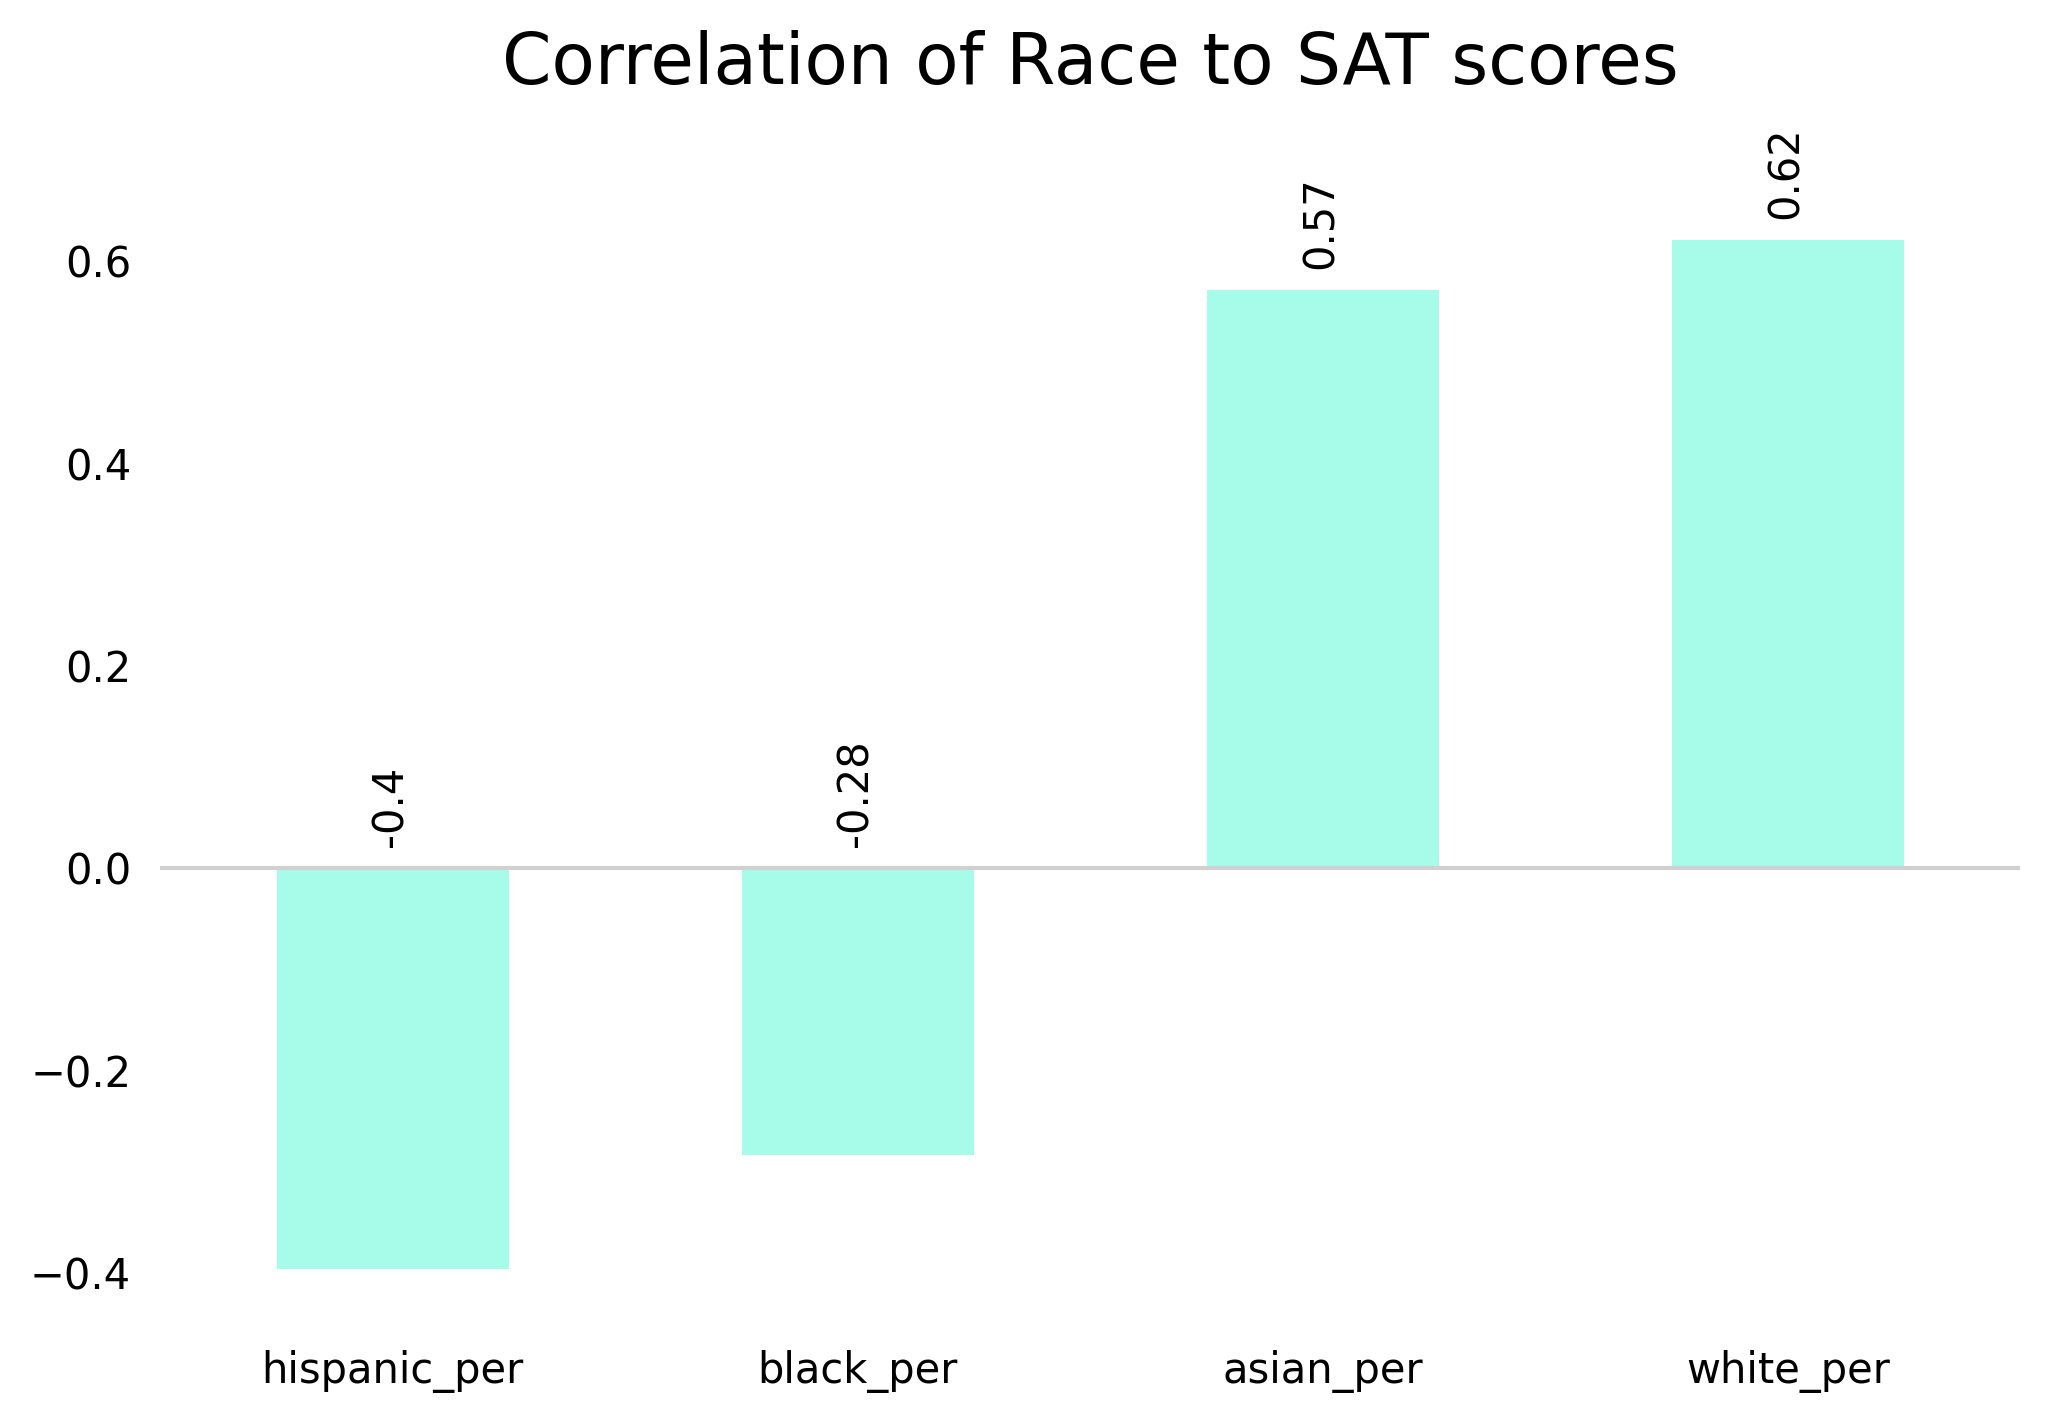

In [28]:
races = ['asian_per', 'white_per', 'black_per', 'hispanic_per']
ax = combined.corr()['sat_score'][races].sort_values().plot.bar(color = '#a7fce9', rot = 0, width = 0.5, figsize = (8, 5))
ax.axhline(y = 0.0, color = '#D0D0D0', linestyle = '-', linewidth = 1)

for key,spine in ax.spines.items():
       spine.set_visible(False)
        
for i in ax.patches:
    ax.annotate(str(round(i.get_height(), 2)),
               (i.get_x() + 0.2, max(i.get_height(), 0) + 0.03),
                rotation = 90
               )
        
ax.tick_params(bottom = False, top = False, left = False, right = False, labelbottom = True) 
ax.set_title('Correlation of Race to SAT scores\n', size = 17)

**Insights:**

-  It appears that White or Asian students correlate positively with ```sat_score```, whereas Black or Hispanic students correlate negatively with ```sat_score```. This may be a result of underfunding for schools in specific regions, which are more likely to have a larger proportion of black or hispanic children. This may also be a result of certain groups, such as Asians, who have a higher propensity for academic pursuits.


- However, it was a little unexpected to see that Whites had a bit stronger positive correlation than Asians; it is commonly reported the other way around.

In [29]:
with warnings.catch_warnings(): # catching warning regarding np.module in Python 3.8.2.
    warnings.filterwarnings('ignore', category = FutureWarning)
    combined.iplot(x = 'hispanic_per',
                   y = 'sat_score',
                   categories = 'boro',
                   text = 'SCHOOL NAME',
                   vline = {'x': combined['hispanic_per'].mean(), 
                            'color': '#000000',
                            'dash': 'dash'
                            },
                   hline = {'y': combined['sat_score'].mean(),
                            'color': '#000000',
                            'dash': 'dash'
                           },
                   colors = {'Manhattan': '#75ffdf',
                             'Bronx': '#00d5ff',
                             'Brooklyn': '#b1acff',
                             'Queens': '#ff78d9',
                             'Staten Island': '#fcb353'
                            },
                   xTitle = 'Hispanic Students Share %',
                   yTitle = 'Avg SAT Score',
                   title = 'Hispanic Students Share | SAT Score by School'
                  )

**Insights:**

- Nearly all Bronx schools (double-click **Bronx** in legend) have below average SAT scores and above average high shares of Hispanic students. Low SAT scores among Hispanics in New York may be caused by confounding variables like violence or poor income. Sadly, there are hardly any Hispanic students in the few premier schools in the Bronx such as Lehman and Bronx High School of Science.


- Schools that specialize in students with insufficient English proficiency are those with very low average SAT scores and very large shares of Hispanic students; those schools are usually named "International". Given that both reading and writing are tested on the SAT, it is expected that these schools perform below average.


High SAT scores and low Hispanic enrollment rates are indicators of extremely selective public high schools with outstanding reputations. Let's compare the racial composition of all these elite institutions, where average *SAT > 1,900* to all other schools. To accomplish this task, we can create a stacked bar to racial makeup of all schools and elite institutions.

In [30]:
list_race = ['asian_num', 'black_num', 'hispanic_num', 'white_num']
top_sat = combined['sat_score'] > 1800

race_dist = pd.DataFrame(data = [combined.loc[:, list_race].sum() / combined.loc[:, list_race].sum().sum(),
                                 combined.loc[top_sat, list_race].sum() / combined.loc[top_sat, list_race].sum().sum()],
                         index = ['All schools', 'Elite schools']) * 100
race_dist.columns = ['Asian', 'Black', 'Hispanic', 'White']
race_dist.astype(int).iplot(kind = 'bar', barmode = 'stack', yTitle = 'Students Share %',
                            title = 'Racial Makeup | NYC High Schools <br>SAT Score > 1,900',
                            colors = {'Asian': '#75ffdf',
                                      'Black': '#00d5ff',
                                      'Hispanic': '#b1acff',
                                      'White': '#ff78d9'}
                            )

**Insights:**
- When compared to all NYC selective high schools, White and particularly Asian students are overrepresented, while Black and Hispanic students are visibly underrepresented.

# 7

## Gender and SAT Scores

Text(0.5, 1.0, 'Correlation of Gender with SAT scores\n')

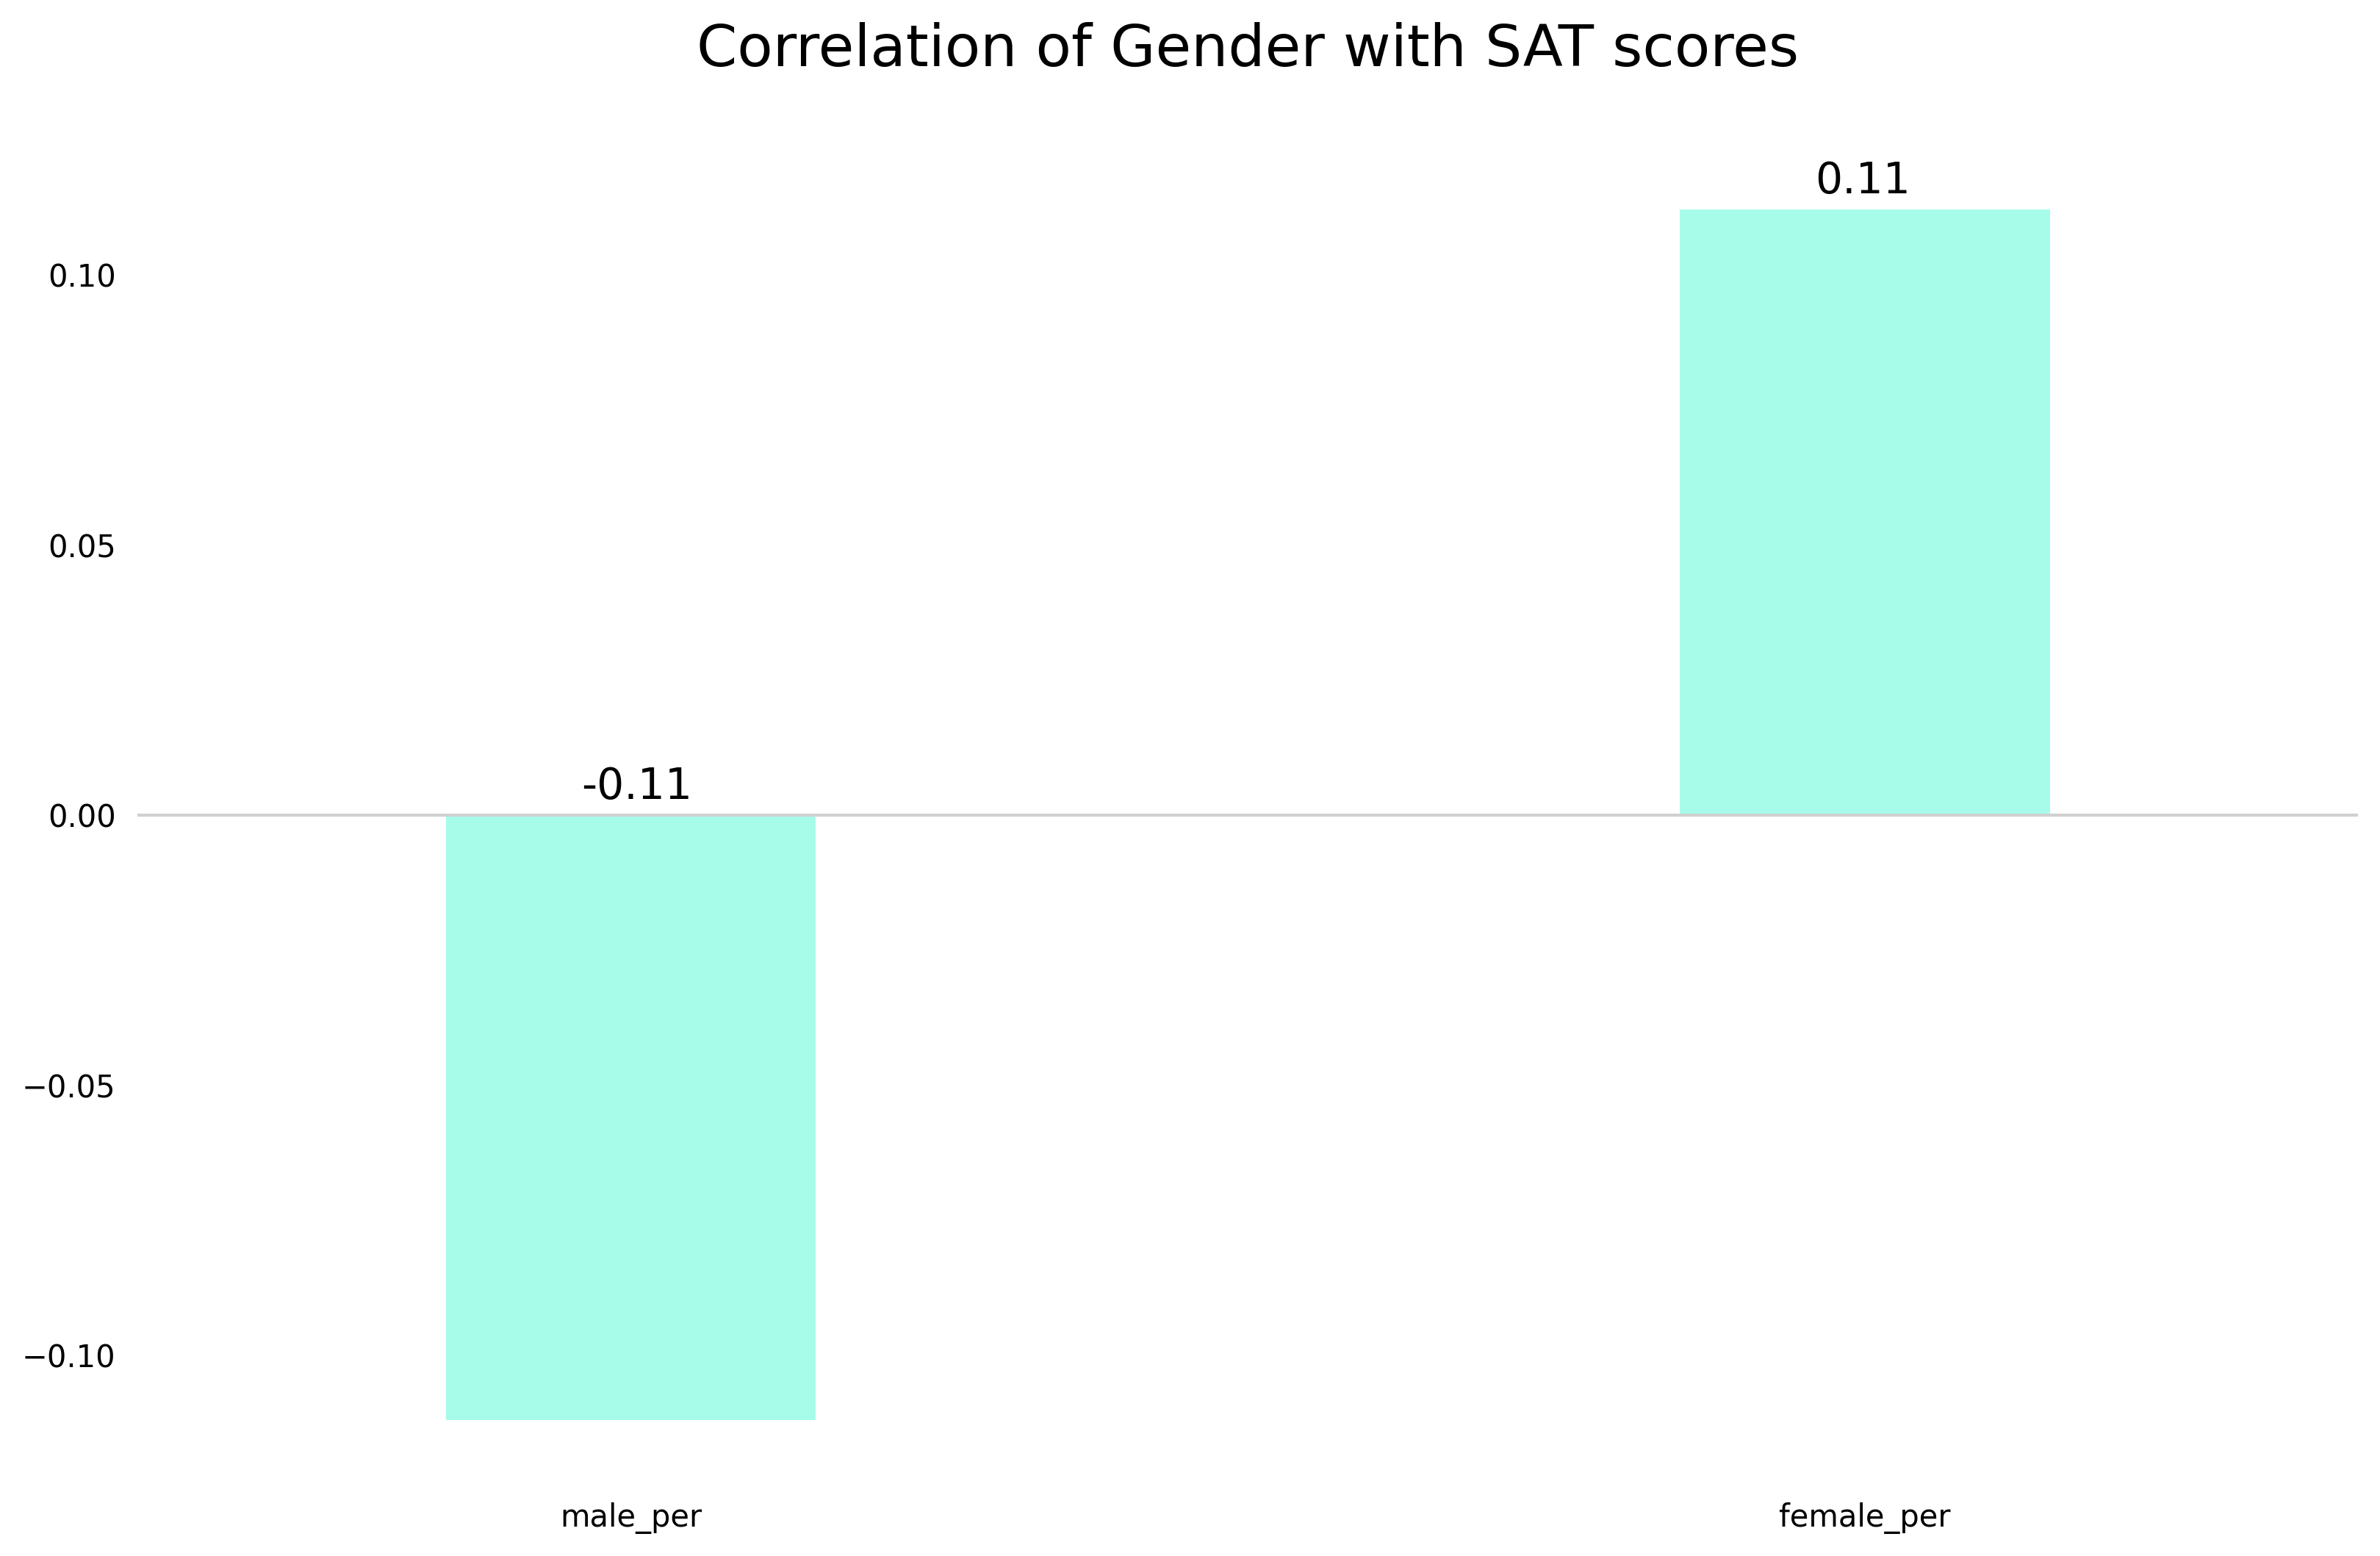

In [31]:
ax = combined.corr()['sat_score'][['male_per','female_per']].plot.bar(rot = 0, color = '#a7fce9', width = 0.3, figsize = (13, 8))
ax.axhline(y = 0.0, color = '#D0D0D0', linestyle = '-', linewidth = 1)
for key,spine in ax.spines.items():
       spine.set_visible(False)
        
for i in ax.patches:
    ax.annotate(str(round(i.get_height(), 2)),
                (i.get_x() + 0.11, max(i.get_height(), 0) + 0.003),
                rotation = 0,
                size = 14
                )
ax.tick_params(bottom = False, top = False, left = False, right = False, labelbottom = True) 

ax.set_title('Correlation of Gender with SAT scores\n', size = 19)

**Insights:**
- It appears that a high number of female students students at a school correlates positively with SAT score, but a high percentage of male students at a school correlates negatively. Even yet, the correlation is just about 0.1.


- Typically, just n-1 dummies of a categorical variable need to be plotted. In this situation, when gender can take on two different values, female will always be symmetrical to male and vice versa.

In [32]:
with warnings.catch_warnings(): # catching warning regarding np.module in Python 3.8.2.
    warnings.filterwarnings('ignore', category = FutureWarning)
    combined.iplot(x = 'female_per',
                   y = 'sat_score',
                   categories = 'boro',
                   text = 'SCHOOL NAME',
                   vline = {'x': combined['female_per'].mean(), 
                            'color': '#000000',
                            'dash': 'dash'
                            },
                   hline = {'y': combined['sat_score'].mean(),
                            'color': '#000000',
                            'dash': 'dash'
                           },
                   colors = {'Manhattan': '#75ffdf',
                             'Bronx': '#00d5ff',
                             'Brooklyn': '#b1acff',
                             'Queens': '#ff78d9',
                             'Staten Island': '#fcb353'
                            },
                   xTitle = 'Female Students Share %',
                   yTitle = 'Avg SAT Score',
                   title = 'Female Students Share | SAT Score by School'
                  )

**Insights:**

- 11 schools with a female student enrollment of at least 60% and SAT perfomances of at least 1,400 are all located Manhattan and Queens areas. There may be less access to a top-notch education for girls in other boroughs.


- The humanities and arts are emphasized mostly in the high performing/female-dominated schools.


- With average SAT scores above 1,800 and a STEM concentration, prestigious schools are majority-male.

# 8

## AP Scores and SAT Scores
It seems obvious that there would be a strong correlation between a school's SAT score and the proportion of students who took AP tests. Let's investigate this connection. 

However, we don't want to bias our findings because ```total_enrollment``` and ```sat_score``` have a strong correlation. Instead, let's focus on the share of students from each institution who took at least one AP test.

In [33]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined['ap_per']

0     0.306
1     0.099
2     0.032
3     0.352
4     0.158
       ... 
358   0.078
359   0.297
360   0.191
361   0.027
362   0.074
Name: ap_per, Length: 363, dtype: float64

In [34]:
with warnings.catch_warnings(): # catching warning regarding np.module in Python 3.8.2.
    warnings.filterwarnings('ignore', category = FutureWarning)
    combined.iplot(x = 'ap_per',
                   y = 'sat_score',
                   categories = 'boro',
                   text = 'SCHOOL NAME',
                   vline = {'x': combined['ap_per'].mean(), 
                            'color': '#000000',
                            'dash': 'dash'
                            },
                   hline = {'y': combined['sat_score'].mean(),
                            'color': '#000000',
                            'dash': 'dash'
                           },
                   colors = {'Manhattan': '#75ffdf',
                             'Bronx': '#00d5ff',
                             'Brooklyn': '#b1acff',
                             'Queens': '#ff78d9',
                             'Staten Island': '#fcb353'
                            },
                   xTitle = 'Students Who Took AP-Test %',
                   yTitle = 'Avg SAT Score',
                   title = 'AP-Test Takers Share | SAT Score by School'
                  )

**Insights:**
It appears that there is a correlation between a school's average SAT score and the share of students who take the AP test; however, the correlation isn't strong. 

Three intresting patterns:

- ***SAT above 1,400***: The percentage of students who take the AP exam and SAT scores appear to be strongly correlated in schools with high SAT scores (over 1,400). When I looked into these schools, I found that they were all quite selective. One theory is that students who attend these schools typically have academic aptitudes above average and gain more from academic placement than students who attend other schools.

- ***AP exam above average and SAT below 1,300:*** These are the schools that may have lower SAT scores due to their concentration on assisting underprivileged populations of students (such as Hispanic and Black) by, for instance, providing more free meals and special education to these children.

- ***Average SAT scores and relatively high AP score:*** I believe that these schools' SAT scores were missing and imputed since practically all of them had SAT scores that are equal to the dataset's average. 

Overall, it appears that the share of AP exam takers is not a reliable predictor of SAT performance.

# 9

## Class Size and SAT Scores

In [35]:
with warnings.catch_warnings(): # catching warning regarding np.module in Python 3.8.2.
    warnings.filterwarnings('ignore', category = FutureWarning)
    combined.iplot(x = 'AVERAGE CLASS SIZE',
                   y = 'sat_score',
                   categories = 'boro',
                   text = 'SCHOOL NAME',
                   vline = {'x': combined['AVERAGE CLASS SIZE'].mean(), 
                            'color': '#000000',
                            'dash': 'dash'
                            },
                   hline = {'y': combined['sat_score'].mean(),
                            'color': '#000000',
                            'dash': 'dash'
                           },
                   colors = {'Manhattan': '#75ffdf',
                             'Bronx': '#00d5ff',
                             'Brooklyn': '#b1acff',
                             'Queens': '#ff78d9',
                             'Staten Island': '#fcb353'
                            },
                   xTitle = 'Avg Class Size',
                   yTitle = 'Avg SAT Score',
                   title = 'Average Class Size | SAT Score by School'
                  )

**Insights:**

- The scatterplot indicates that there is no clear correlation between the SAT score and the average class size.

# 10

## Conclusion
The key results are:

- Black and Hispanic students do worse than their white counterparts, according to statistical evidence. They attend schools in less secure areas and are less frequently accepted into the prestigious high schools in their borough.


- Male students make up a large share of the student body in top STEM-focused schools, whereas female students tend to predominately attend prestigious high schools with a non-STEM concentration.


- Advanced Placement (AP) classes may not necessarily provide the best SAT exam preparation.

***Acknowledges:*** *SAT scores are not the only important factor to consider when assessing the level as well as quality of education.*